In [2]:
import os

root_path = "dataset"

def count_files(path):
    return len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]) if os.path.exists(path) else 0

summary = []

for mode in ["Training", "Testing"]:
    mode_path = os.path.join(root_path, mode)
    if os.path.isdir(mode_path):
        for category in os.listdir(mode_path):
            category_path = os.path.join(mode_path, category)
            if os.path.isdir(category_path):
                file_count = count_files(category_path)
                summary.append(f"{mode}/{category} -> {file_count} files")

for line in summary:
    print(line)

Training/Fresh_Gills -> 613 files
Training/Nonfresh_Eyes -> 1028 files
Training/Fresh_Eyes -> 233 files
Training/Nonfresh_Gills -> 1265 files
Testing/Fresh_Gills -> 80 files
Testing/Nonfresh_Eyes -> 257 files
Testing/Fresh_Eyes -> 134 files
Testing/Nonfresh_Gills -> 316 files


In [17]:
#  Import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [18]:
# Verifikasi apakah GPU tersedia
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
import tensorflow as tf

# Verifikasi GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("GPU tidak ditemukan, menggunakan CPU.")
else:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Menggunakan GPU.")

Menggunakan GPU.


In [ ]:
#  Load dataset dari folder
batch_size = 32
img_size = (224, 224)

train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/Training",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=True,
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/Testing",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=False  # Penting untuk evaluasi
)

class_names = train_ds.class_names
print("Class names:", class_names)

Found 3139 files belonging to 4 classes.


2025-05-14 16:40:11.428425: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-14 16:40:11.428459: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-14 16:40:11.428472: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-14 16:40:11.428506: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-14 16:40:11.428516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 787 files belonging to 4 classes.


In [5]:
#  Tambahkan augmentasi data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

In [ ]:
# Preprocessing untuk EfficientNetV2
def preprocess(image, label):
    image = tf.keras.applications.efficientnet_v2.preprocess_input(image)
    return image, label

In [6]:
# Terapkan augmentasi hanya ke training
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
#  Hitung class weight agar adil untuk data tidak seimbang
base_model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet",
    pooling='avg'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy", 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

2025-05-14 16:40:16.587433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Class weights: {0: 3.3680257510729614, 1: 1.280179445350734, 2: 0.7633754863813229, 3: 0.6203557312252964}


2025-05-14 16:40:54.432060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Bangun model klasifikasi
base_model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet",
    pooling='avg'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy", 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

In [9]:
# Latih model
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.8232 - loss: 0.4262 - val_accuracy: 0.9771 - val_loss: 0.1534
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9882 - loss: 0.0594 - val_accuracy: 0.9987 - val_loss: 0.0293
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.9936 - loss: 0.0273 - val_accuracy: 1.0000 - val_loss: 0.0229
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.9976 - loss: 0.0153 - val_accuracy: 1.0000 - val_loss: 0.0104
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.9986 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 0.0071
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.9965 - loss: 0.0096 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9993 - loss: 0.0059 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.9977 - loss: 0.0102 - val_accuracy: 1.0000 - v

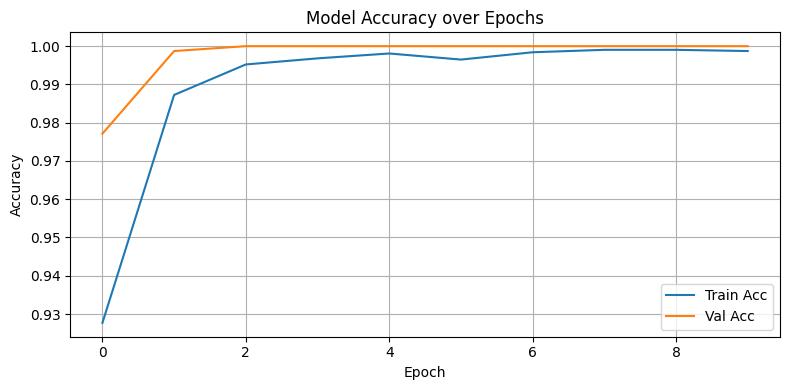

Found 787 files belonging to 4 classes.

📋 Classification Report:



2025-05-14 17:15:23.104324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


NameError: name 'class_names' is not defined

In [16]:
#  Visualisasi Akurasi dan Evaluasi Model
y_true = np.concatenate([np.argmax(y, axis=1) for x, y in val_ds], axis=0)
y_pred = np.argmax(model.predict(val_ds), axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()